In [7]:
from llm_base import LLM

llm = LLM(
    model="llama-3.1-8b-instant",
    api_key_env="GROQ_API_KEY",
    endpoint="https://api.groq.com/openai/v1/chat/completions"
)


base_prompt = """
You are a tone-based news classifier.
Classify the following news text as “fake” or “real” based only on tone, style, emotional charge, and linguistic cues.

Important rules:

Do NOT check factual accuracy.

Do NOT use external knowledge.

Do NOT verify if the information is true in reality.

Judge ONLY the tone and writing style.

Your entire output must be only one word: “fake” or “real”, with no explanation.

Text:
{}
"""

def judge_content_based(sentence):
    prompt = base_prompt.format(sentence)
    response = llm.generate(prompt=prompt, temperature=0)
    return response.strip().lower()

In [8]:
import pandas as pd
import numpy as np
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine
from importlib import reload
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

USER = os.getenv("POSTGRES_USER")
PASSWORD = os.getenv("POSTGRES_PASSWORD")
DB = os.getenv("POSTGRES_DB")
PORT = os.getenv("POSTGRES_PORT")
HOST = os.getenv("POSTGRES_HOST", "localhost")

# Criar engine SQLAlchemy
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")


# test1_results -> RAG DDGO
# test3_results -> LLM Alone
# test4_results -> RAG Google
# teste_ner_google_results
# teste_ner_ddgo_results

table_target = 'teste_ner_ddgo'

df_com_rag = pd.read_sql(f"SELECT * FROM {table_target}_results", engine)
df_sem_rag = pd.read_sql("SELECT * FROM test3_results", engine)
df = df_sem_rag.drop(['id'], axis=1).merge(df_com_rag.drop(['id'], axis=1), on=['search_title', 'shuffle_id', 'true_class'], suffixes=('_sem_rag', '_com_rag'))
df

,search_title,shuffle_id,response_sem_rag,true_class,response_com_rag
0,Supreme Court Justice Ginsburg 'regrets' Trump...,0,fake,real,real
1,DOZENS Of GOP Foreign Policy Experts Pledge T...,1,fake,fake,fake
2,REPORT: Trump Laughed After Woman Was Grabbed...,2,fake,fake,fake
3,"In North Dakota, Trump finds Democrat willing ...",3,fake,real,real
4,"Flash floods kill five in Malaysia, army deplo...",4,real,real,real
...,...,...,...,...,...
1995,Conservative Texas Lt. Governor Tweets Vile B...,573,real,fake,real
1996,HILLARY THROWS HER WEALTH AND STATUS Into The ...,594,fake,fake,fake
1997,TOLD TO SURRENDER: Former Trump Campaign Manag...,609,fake,fake,fake
1998,Trump BEGGED This Singer To Perform At His In...,623,fake,fake,fake


Text(0.5, 36.72222222222221, 'LLM Output')

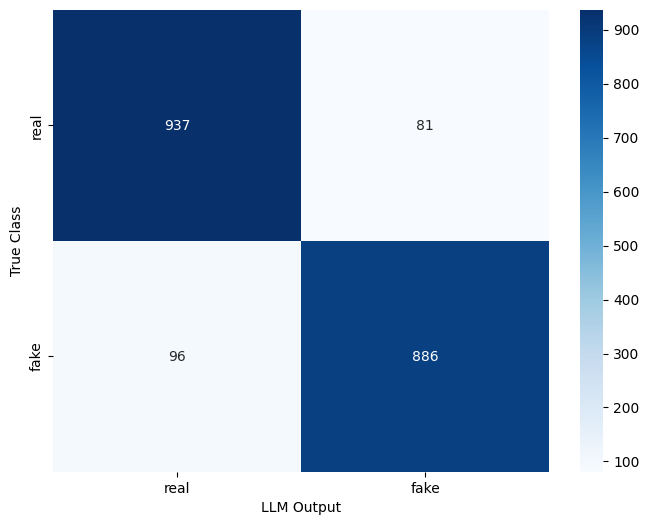

In [9]:
y_true = df['true_class']
y_pred = df['response_com_rag']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

In [10]:
df['response_tom'] = df['search_title'].apply(judge_content_based)

C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.groq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.groq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\urllib3\connectionpool.py:1097: InsecureRequest

Text(0.5, 36.72222222222221, 'LLM Output')

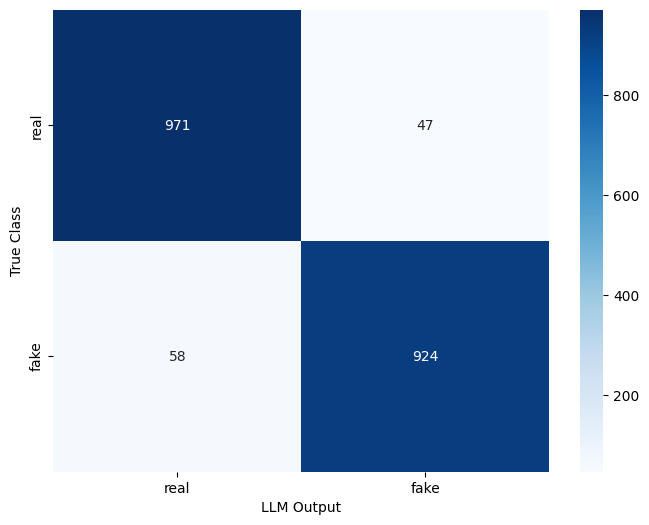

In [11]:

y_true = df['true_class']
y_pred = df['response_tom']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

Text(0.5, 36.72222222222221, 'LLM Output')

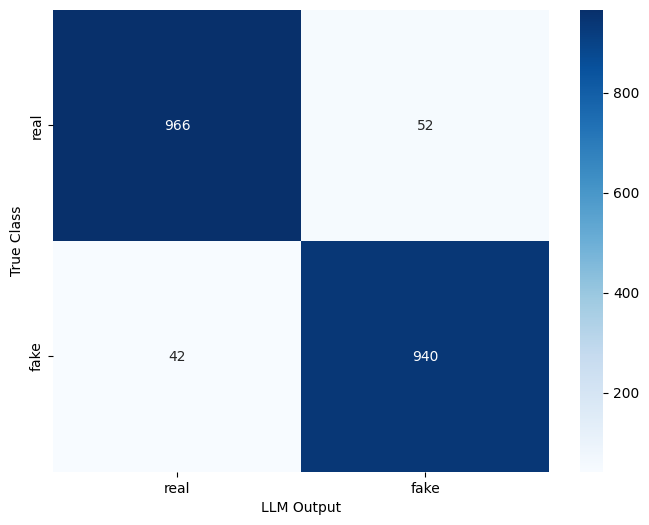

In [12]:
cols = ['response_sem_rag', 'response_com_rag', 'response_tom']
df['response_final'] = df[cols].apply(
    lambda row: 'fake' if (row == 'fake').sum() > (row == 'real').sum() else 'real',
    axis=1
)

y_true = df['true_class']
y_pred = df['response_final']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')

In [13]:
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
fake,0.947581,0.957230,0.952381,982.000
real,0.958333,0.948919,0.953603,1018.000
accuracy,0.953000,0.953000,0.953000,0.953
macro avg,0.952957,0.953075,0.952992,2000.000
weighted avg,0.953054,0.953000,0.953003,2000.000


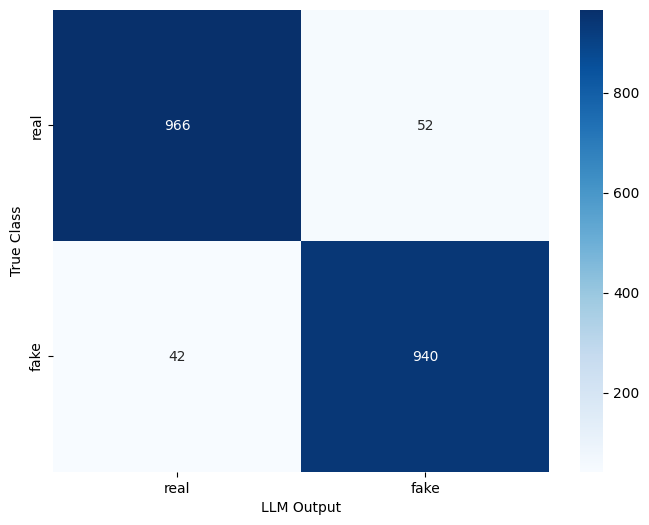

In [14]:
y_true = df['true_class']
y_pred = df['response_final']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')
plt.savefig("confusion_matrix.png")  # Salva a figura como PNG
